*Names : ID*\
Ghada Fares : 20106938\
Patrick Nashaat : 20106520\
Amr Gamal : 20104533

In [1]:
pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
import torch


In [3]:
squad_dataset = load_dataset("squad_v2")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [4]:
def sample_dataset(dataset, num_samples):
    return dataset.shuffle(seed=42).select(range(num_samples))

small_squad = DatasetDict({
    "train": sample_dataset(squad_dataset["train"], 2000),  # 2000 examples
    "validation": sample_dataset(squad_dataset["validation"], 500),  # 500 examples
})


In [5]:
tokenizer = AutoTokenizer.from_pretrained("Ghadafares2/bert-large-uncased-finetuned-squad")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation=True,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = inputs.pop("overflow_to_sample_mapping")
    offset_mapping = inputs.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = inputs["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = inputs.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        if len(answers["answer_start"]) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                start_positions.append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                end_positions.append(token_end_index + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

tokenized_squad = small_squad.map(preprocess_function, batched=True, remove_columns=small_squad["train"].column_names)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [7]:
model = AutoModelForQuestionAnswering.from_pretrained("Ghadafares2/bert-large-uncased-finetuned-squad")


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
training_args = TrainingArguments(
    "Ghadafares2/bert-large-uncased-finetuned-squad",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=50,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["validation"],
    tokenizer=tokenizer,
)


<ipython-input-9-2ff3d9eaad0c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.194000,1.015716
2,0.319800,1.291940
3,0.131900,1.495247


TrainOutput(global_step=381, training_loss=0.5580489241232084, metrics={'train_runtime': 1906.4795, 'train_samples_per_second': 3.191, 'train_steps_per_second': 0.2, 'total_flos': 4237690005080064.0, 'train_loss': 0.5580489241232084, 'epoch': 3.0})

In [11]:
trainer.evaluate()


{'eval_loss': 1.4952471256256104,
 'eval_runtime': 33.3934,
 'eval_samples_per_second': 15.243,
 'eval_steps_per_second': 0.958,
 'epoch': 3.0}

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
print(small_squad["train"][0])  # Check a sample from the dataset


{'id': '56e0f3907aa994140058e80a', 'title': 'Canon_law', 'context': 'The Roman Catholic Church canon law also includes the main five rites (groups) of churches which are in full union with the Roman Catholic Church and the Supreme Pontiff:', 'question': 'What term characterizes the intersection of the rites with the Roman Catholic Church?', 'answers': {'text': ['full union'], 'answer_start': [104]}}


In [15]:
model.save_pretrained("./qa_model")
tokenizer.save_pretrained("./qa_model")


('./qa_model/tokenizer_config.json',
 './qa_model/special_tokens_map.json',
 './qa_model/vocab.txt',
 './qa_model/added_tokens.json',
 './qa_model/tokenizer.json')

In [23]:
from huggingface_hub import notebook_login

notebook_login()

In [26]:
from huggingface_hub import create_repo

trainer.push_to_hub(commit_message="Training complete")


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Ghadafares2/results/commit/9488385dc8731390894b9d0629ddf6300f6cde87', commit_message='Training complete', commit_description='', oid='9488385dc8731390894b9d0629ddf6300f6cde87', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Ghadafares2/results', endpoint='https://huggingface.co', repo_type='model', repo_id='Ghadafares2/results'), pr_revision=None, pr_num=None)

In [27]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

model = AutoModelForQuestionAnswering.from_pretrained("Ghadafares2/bert-large-uncased-finetuned-squad")
tokenizer = AutoTokenizer.from_pretrained("Ghadafares2/bert-large-uncased-finetuned-squad")


config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [22]:
def answer_question(question, context):
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True, max_length=384, stride=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    outputs = model(**inputs)

    # Move logits to CPU if needed for further processing
    start_logits = outputs.start_logits.cpu()
    end_logits = outputs.end_logits.cpu()

    answer_start = torch.argmax(start_logits)
    answer_end = torch.argmax(end_logits) + 1
    answer = tokenizer.decode(inputs["input_ids"][0][answer_start:answer_end])
    return answer





jax, pytorch and tensorflow


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [18]:

from datasets import load_dataset
from transformers import BertTokenizerFast

# Load the dataset and tokenizer
dataset = load_dataset("squad_v2")
validation_dataset = dataset['validation']

# Initialize the tokenizer
model_name = "Ghadafares2/bert-large-uncased-finetuned-squad"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# Tokenize the validation set
def prepare_data(examples):
    return tokenizer(
        examples['question'],
        examples['context'],
        truncation=True,
        padding="max_length",
        max_length=384,
    )

tokenized_val = validation_dataset.map(prepare_data, batched=True)


Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [19]:

# Collect true and predicted labels for visualization
true_start_positions = []
true_end_positions = []
predicted_start_positions = []
predicted_end_positions = []

# Run inference on the validation set and collect results
predictions, labels, _ = trainer.predict(tokenized_val)

# Extract predictions
start_logits, end_logits = predictions
start_preds = np.argmax(start_logits, axis=1)
end_preds = np.argmax(end_logits, axis=1)

# Extract ground truth labels
for batch in tokenized_val:
    true_start_positions.append(batch["answers"]["answer_start"][0] if batch["answers"]["text"] else 0)
    true_end_positions.append(batch["answers"]["answer_start"][0] + len(batch["answers"]["text"][0]) if batch["answers"]["text"] else 0)

# Store predictions for comparison
predicted_start_positions = start_preds
predicted_end_positions = end_preds


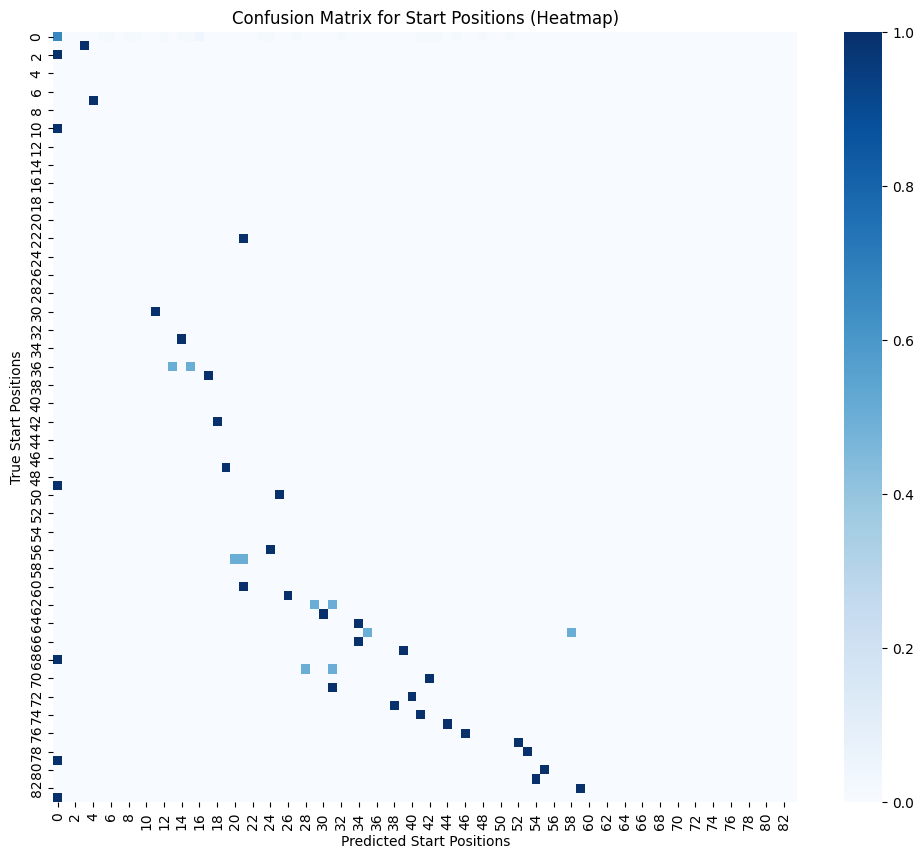

In [20]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Limit dataset size for visualization to avoid memory issues
subset_size = 100  # Adjust this value if you need more or fewer samples
true_start_positions = true_start_positions[:subset_size]
predicted_start_positions = predicted_start_positions[:subset_size]

# Generate a confusion matrix with reduced data
conf_matrix_start = confusion_matrix(true_start_positions, predicted_start_positions, normalize='true')

# Display a heatmap for better visualization
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_start, cmap="Blues")
plt.title("Confusion Matrix for Start Positions (Heatmap)")
plt.xlabel("Predicted Start Positions")
plt.ylabel("True Start Positions")
plt.show()


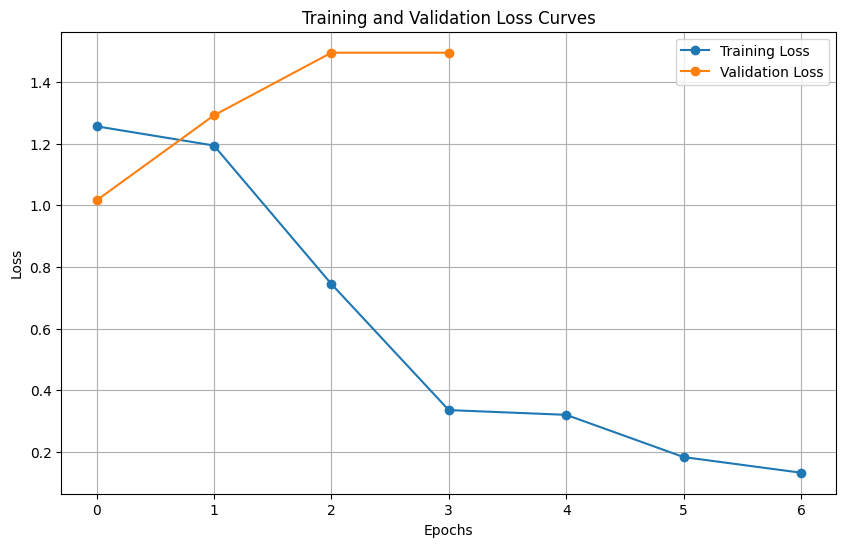

In [21]:
import matplotlib.pyplot as plt

# Extract training and evaluation loss from the logs
train_loss = trainer.state.log_history
train_losses = [entry['loss'] for entry in train_loss if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in train_loss if 'eval_loss' in entry]

# Plot Training and Validation Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(eval_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


## Testing

In [35]:
model = model.to(device)

context = """

Beyoncé Giselle Knowles-Carter (/biˈɒnseɪ/ ⓘ, bee-ON-say;[6] born September 4, 1981)[7] is an American singer, songwriter, and businesswoman. An influential figure in popular music, she has been noted for her vocal ability, dynamic performances, and artistic expression."""
question = "when was she born?"
print(answer_question(question, context))

september 4, 1981


In [47]:
model = model.to(device)

context = """
AAST (Arab Academy for Science, Technology, and Maritime Transport) is a prestigious educational institution located in Alexandria, Egypt. Established in 1972 as part of the Arab League's efforts to promote higher education and professional development in the Arab world, AAST has grown into one of the leading universities in the region. It offers a wide range of undergraduate and graduate programs in various fields such as engineering, computer science, business administration, maritime studies, and applied sciences.
"""
question = "What are the fields available ?"
print(answer_question(question, context))

engineering, computer science, business administration, maritime studies, and applied sciences
